In [1]:
import numpy as np
import pandas as pd
from pybedtools import BedTool
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')

gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons_df = pd.read_csv(gencode_exons_file, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

gencode_exons_bed = BedTool.from_dataframe(gencode_exons_df)


vastdb_exons_df = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
vastdb_exons_df = vastdb_exons_df.dropna()
vastdb_exons_cols = list(vastdb_exons_df.columns)
vastdb_exons_df['chrom'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[0])
vastdb_exons_df['start'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
vastdb_exons_df['end'] = vastdb_exons_df.CO_A.apply(lambda x: x.split('-')[1])
vastdb_exons_cols = ['chrom', 'start', 'end'] + vastdb_exons_cols
vastdb_exons_df = vastdb_exons_df[vastdb_exons_cols]

vastdb_exons_df = vastdb_exons_df.loc[(~vastdb_exons_df.COMPLEX.isin(['MIC-S', 'MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])) & (vastdb_exons_df.EVENT.apply(lambda x: x.startswith('HsaEX')))]
vastdb_exons_df = vastdb_exons_df.loc[(~ vastdb_exons_df.COMPLEX.apply(lambda x: (x.startswith('ME') or (x == 'A_NA') or (x == 'ANN') or x == 'NA*')))]
vastdb_exons_df = vastdb_exons_df[[x for x in vastdb_exons_df.columns if x not in ['Seq_C1', 'Seq_A', 'Seq_C2']]]
vastdb_exons_df['strand'] = vastdb_exons_df.REF_CO.apply(lambda x: x.split(':')[-1])

intron_start_list = []
intron_end_list = []
for idx, row in vastdb_exons_df.iterrows():
    strand = row.strand
    if strand == '+':
        intron_start = int(row.CO_C1.split('-')[-1])
        intron_end = int(row.CO_C2.split('-')[0].split(':')[1])
    else:
        intron_start = int(row.CO_C2.split('-')[-1])
        intron_end = int(row.CO_C1.split('-')[0].split(':')[1])
        
    intron_start_list.append(intron_start)
    intron_end_list.append(intron_end)

vastdb_introns_df = pd.DataFrame()
vastdb_introns_df['chrom'] = list(vastdb_exons_df.chrom)
vastdb_introns_df['start'] = intron_start_list
vastdb_introns_df['end'] = intron_end_list
vastdb_introns_df['GENE'] = list(vastdb_exons_df.GENE)
vastdb_introns_df['EVENT'] = list(vastdb_exons_df.EVENT)
vastdb_introns_df['strand'] = list(vastdb_exons_df.strand)

vastdb_introns_bed = BedTool.from_dataframe(vastdb_introns_df).sort()
vastdb_exons_bed = BedTool.from_dataframe(vastdb_exons_df).sort()


# snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')
snmf_cassette_exons_bed = BedTool.from_dataframe(snmf_cassette_exons)

snmf_vastdb_cassette_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, wo=True).to_dataframe(
    names = list(snmf_cassette_exons.columns) + [f'{x}_vastdb' for x in vastdb_exons_df.columns] + ['overlaps']
)


intron_start_vastdb = []
intron_end_vastdb = []
for idx, row in snmf_vastdb_cassette_exons.iterrows():
    if row.strand_vastdb == '+':
        intron_start = row.CO_C1_vastdb
        intron_end = row.CO_C2_vastdb
    else:
        intron_start = row.CO_C2_vastdb
        intron_end = row.CO_C1_vastdb
    intron_start = int(intron_start.split('-')[-1])
    intron_end = int(intron_end.split(':')[-1].split('-')[0])

    intron_start_vastdb.append(intron_start)
    intron_end_vastdb.append(intron_end)

snmf_vastdb_cassette_exons['intron_start_vastdb'] = intron_start_vastdb
snmf_vastdb_cassette_exons['intron_end_vastdb'] = intron_end_vastdb

snmf_vastdb_cassette_exons_confirmed = snmf_vastdb_cassette_exons.loc[
(snmf_vastdb_cassette_exons.intron_start == snmf_vastdb_cassette_exons.intron_start_vastdb) & (snmf_vastdb_cassette_exons.intron_end == snmf_vastdb_cassette_exons.intron_end_vastdb)
]

In [3]:
snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

/tmp/jobs/41557464/ipykernel_40422/3589894801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[


In [4]:
def load_matrices_per_tissue(tissue, annotation, exon_type):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    
    col_names += pos_names
    fk1 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking1.mat.gz', sep='\t', skiprows=1,
                             names=col_names)

    fk2 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking2.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)
    
    exon = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.exon.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)

    return fk1, exon, fk2
    
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')


col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
gencode_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/gencode/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])


snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_gencode_fk1 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking1.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])
snmf_gencode_fk2 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking2.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'gencode', 'cassette_exon')
gencode_exon = exon[['chrom', 'start', 'end']].copy()
gencode_exon['intron_start'] = fk1.end
gencode_exon['intron_end'] = fk2.start

gencode_exon['annot'] = gencode_exon.chrom + ':' + gencode_exon.start.astype(str) + ':' + gencode_exon.end.astype(str) + ':'+ gencode_exon.intron_start.astype(str) + ':' + gencode_exon.intron_end.astype(str) 

snmf_exon = snmf_gencode_cassette_exons[['chrom', 'start', 'end']].copy()
snmf_exon['intron_start'] = snmf_gencode_fk1.end
snmf_exon['intron_end'] = snmf_gencode_fk2.start

snmf_exon['annot'] = snmf_exon.chrom + ':' + snmf_exon.start.astype(str) + ':' + snmf_exon.end.astype(str) + ':' + snmf_exon.intron_start.astype(str) + ':' + snmf_exon.intron_end.astype(str) 

In [5]:
snmf_gencode_exons = snmf_cassette_exons_bed.intersect(gencode_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)
snmf_vastdb_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)

snmf_vastdb_exons['annot'] = snmf_vastdb_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

snmf_gencode_exons['annot'] = snmf_gencode_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

# snmf_junctions_cassette_exons

snmf_cassette_exons['annot'] =  snmf_cassette_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

exons_by_both = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(pd.Index(
    snmf_vastdb_cassette_exons_confirmed.annot).intersection(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))))].transcripts)

In [6]:
snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_junctions_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/junctions.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

In [7]:
transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).unique()
)

In [8]:
transcripts_annotated

Index(['ENSG00000000457.isoform_1|ENSG00000000457.isoform_10|ENSG00000000457.isoform_9|ENSG00000000457.isoform_3|ENSG00000000457.isoform_7|ENSG00000000457.isoform_4|ENSG00000000457.isoform_5|ENSG00000000457.isoform_8',
       'ENSG00000000460.isoform_1|ENSG00000000460.isoform_2|ENSG00000000460.isoform_3',
       'ENSG00000000938.isoform_1|ENSG00000000938.isoform_2|ENSG00000000938.isoform_4|ENSG00000000938.isoform_3',
       'ENSG00000000938.isoform_5', 'ENSG00000001036.isoform_7',
       'ENSG00000001084.isoform_2|ENSG00000001084.isoform_4',
       'ENSG00000001084.isoform_5', 'ENSG00000001460.isoform_1',
       'ENSG00000001461.isoform_1|ENSG00000001461.isoform_4',
       'ENSG00000001461.isoform_1|ENSG00000001461.isoform_4|ENSG00000001461.isoform_2|ENSG00000001461.isoform_5',
       ...
       'ENSG00000281106.isoform_4', 'ENSG00000283071.isoform_1',
       'ENSG00000283361.isoform_1', 'ENSG00000283361.isoform_3',
       'ENSG00000283361.isoform_4', 'ENSG00000283361.isoform_6',
     

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *


import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages


def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


loading modules
some more modules
custom-made modules
finished loading modules


In [4]:
def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, ylim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if ylim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 0].set_xlim(ylim)
                ax.set_ylim(ylim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)


In [5]:
gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_file, sep='\t')
gencode_exons_bed = BedTool.from_dataframe(gencode_exons)

# snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
# snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
#                                                  'transcript_id', 'strand', 'factors', 'exon_id'])

bad_exons = snmf_cassette_exons.loc[~snmf_cassette_exons.transcripts.isin(transcripts_annotated)]
bad_exons_bed = BedTool.from_dataframe(bad_exons)

bad_overlap = bad_exons_bed.intersect(gencode_exons_bed, wo=True).to_dataframe(
    names = list(bad_exons.columns) + [f'{x}_gencode' for x in gencode_exons.columns] + ['overlap'])#.shape

bad_no_overlap = bad_exons_bed.intersect(gencode_exons_bed, v=True).to_dataframe(
    names = list(bad_exons.columns))#.shape

NameError: name 'transcripts_annotated' is not defined

In [12]:
bad_exons = snmf_cassette_exons.loc[~snmf_cassette_exons.transcripts.isin(transcripts_annotated)]
bad_exons_bed = BedTool.from_dataframe(bad_exons)

In [13]:
bad_overlap = bad_exons_bed.intersect(gencode_exons_bed, wo=True).to_dataframe(
    names = list(bad_exons.columns) + [f'{x}_gencode' for x in gencode_exons.columns] + ['overlap'])#.shape

In [14]:
bad_no_overlap = bad_exons_bed.intersect(gencode_exons_bed, v=True).to_dataframe(
    names = list(bad_exons.columns))#.shape

In [15]:
len(bad_overlap.exon_name.unique())

2080

In [16]:
len(bad_overlap.loc[((bad_overlap.end == bad_overlap.end_gencode) | (bad_overlap.start == bad_overlap.start_gencode))].exon_name.unique())

1533

In [17]:
bad_no_overlap

,chrom,start,end,gene,exon_coordinates,strand,intron_start,intron_end,flanking1_start,flanking2_end,transcripts,exon_name,annot
0,chr1,954960,954976,ENSG00000188976,chr1:954960-954976,-,954523,955923,954004,956013,ENSG00000188976.isoform_3,ENSG00000188976:1,chr1:954960:954976:954523:955923
1,chr1,1758068,1758128,ENSG00000008130,chr1:1758068-1758128,-,1757310,1761952,1757181,1761995,ENSG00000008130.isoform_3,ENSG00000008130:1,chr1:1758068:1758128:1757310:1761952
2,chr1,1935732,1937538,ENSG00000142609,chr1:1935732-1937538,-,1930336,1938855,1930060,1938988,ENSG00000142609.isoform_2,ENSG00000142609:1,chr1:1935732:1937538:1930336:1938855
3,chr1,1949628,1952658,ENSG00000142609,chr1:1949628-1952658,-,1947054,1955691,1946990,1955850,ENSG00000142609.isoform_2,ENSG00000142609:1,chr1:1949628:1952658:1947054:1955691
4,chr1,2155079,2155661,ENSG00000067606,chr1:2155079-2155661,+,2150978,2155995,2150790,2156092,ENSG00000067606.isoform_9,ENSG00000067606:1,chr1:2155079:2155661:2150978:2155995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5046,chrX,153502513,153502567,ENSG00000182492,chrX:153502513-153502567,+,153495113,153504621,153494931,153506076,ENSG00000182492.isoform_1,ENSG00000182492:1,chrX:153502513:153502567:153495113:153504621
5047,chrX,155288366,155288540,ENSG00000155962,chrX:155288366-155288540,-,155280068,155298785,155279962,155298910,ENSG00000155962.isoform_2,ENSG00000155962:1,chrX:155288366:155288540:155280068:155298785
5048,chrX,155288366,155289854,ENSG00000155962,chrX:155288366-155289854,-,155280068,155298785,155279962,155298910,ENSG00000155962.isoform_4,ENSG00000155962:1,chrX:155288366:155289854:155280068:155298785
5049,chrX,155509848,155510061,ENSG00000185973,chrX:155509848-155510061,-,155507134,155511673,155504817,155511792,ENSG00000185973.isoform_1,ENSG00000185973:1,chrX:155509848:155510061:155507134:155511673


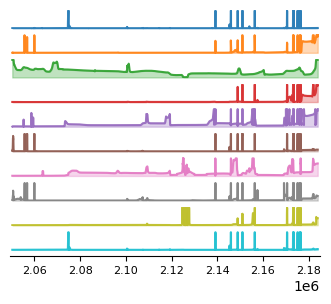

In [18]:
rds = load_ebpmf_gene('ENSG00000067606')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000067606', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

In [10]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


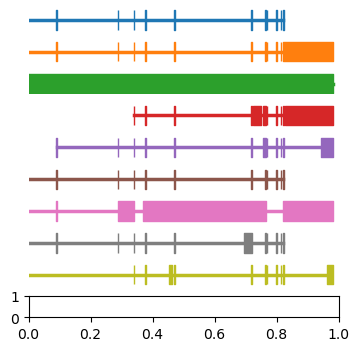

In [20]:
fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])+80000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000067606', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

In [99]:
snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000067606.isoform_9']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
2102,chr1,2121489,2124384,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_1
2115,chr1,2148872,2148924,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_2
2128,chr1,2150790,2150978,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_3
2130,chr1,2155079,2155661,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_4
2133,chr1,2155995,2156092,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_5
2143,chr1,2169518,2169604,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_6
2151,chr1,2172055,2172190,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_7
2158,chr1,2172301,2172388,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_8
2166,chr1,2173897,2174016,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_9
2171,chr1,2174754,2174833,ENSG00000067606,ENSG00000067606.isoform_9,+,factor_9,exon_10


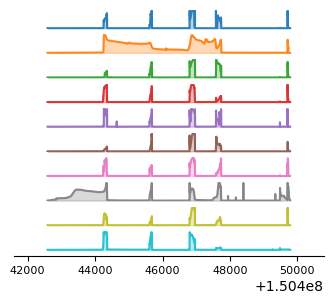

In [117]:
rds = load_ebpmf_gene('ENSG00000164587')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000164587', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

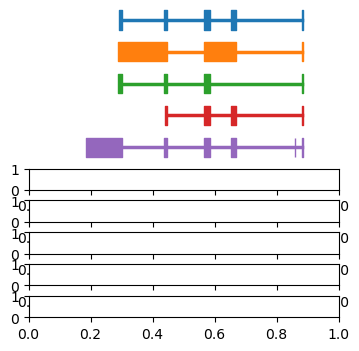

In [118]:
fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000164587', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

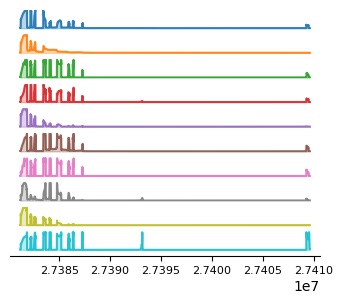

In [184]:
rds = load_ebpmf_gene('ENSG00000115241')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000115241', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

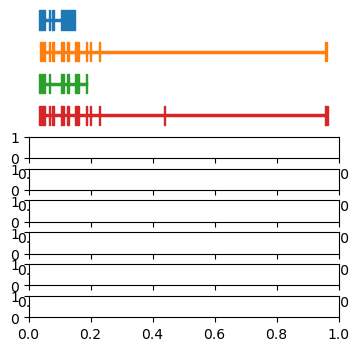

In [185]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000115241', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

In [186]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000115241.csv.gz', index_col=0)
counts.index = [x.split('.')[0] for x in counts.index]


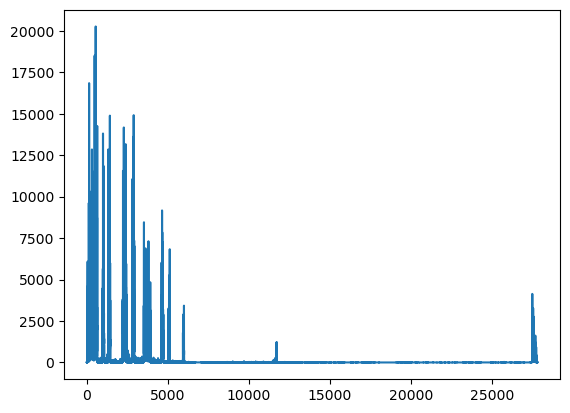

In [187]:
plt.plot(np.array(counts.sum(axis=0)))

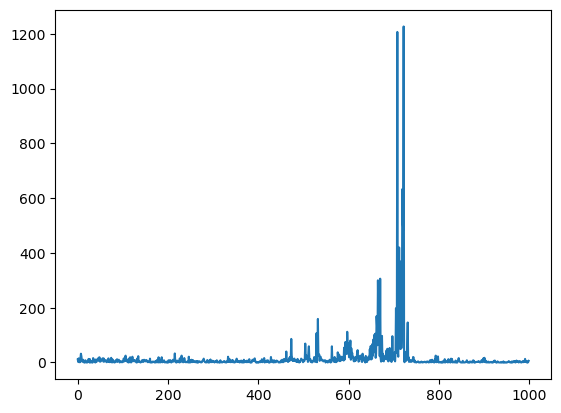

In [193]:
plt.plot(np.array(counts.sum(axis=0))[11000:12000])

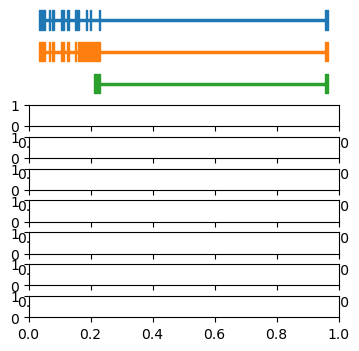

In [188]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000115241', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

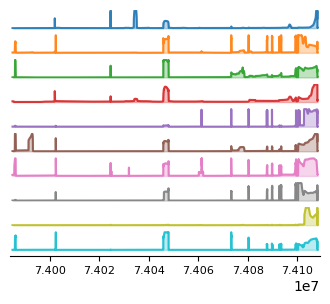

In [172]:
rds = load_ebpmf_gene('ENSG00000187605')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000187605', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

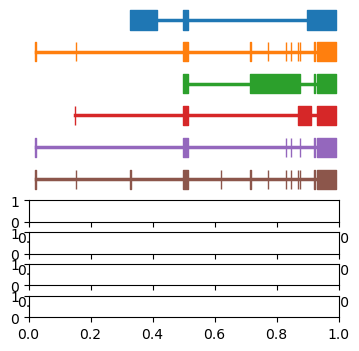

In [173]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000187605', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

In [174]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000187605.csv.gz', index_col=0)
counts.index = [x.split('.')[0] for x in counts.index]


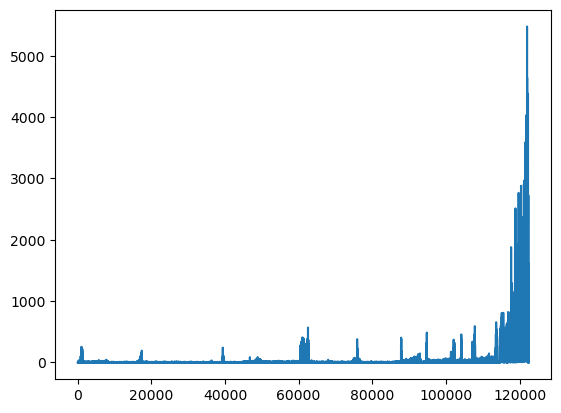

In [175]:
plt.plot(np.array(counts.sum(axis=0)))

In [125]:
gencode_exons['chrom'] = gencode_exons['#chrom']

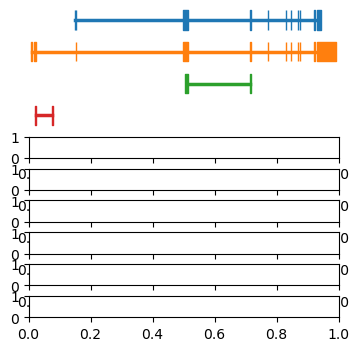

In [176]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000187605', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

In [130]:
gencode_exons.loc[gencode_exons.gene_id == 'ENSG00000097007'].transcript_id.unique()

array(['ENST00000372348', 'ENST00000393293', 'ENST00000318560'],
      dtype=object)

In [133]:
gencode_exons.loc[gencode_exons.transcript_id == 'ENST00000318560']

,#chrom,start,end,gene_id,gene_name,strand,gene_type,transcript_id,transcript_type,chrom
1576683,chr9,130835254,130835525,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576685,chr9,130854064,130854237,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576687,chr9,130854801,130855096,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576689,chr9,130862763,130863035,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576691,chr9,130872129,130872213,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576693,chr9,130872860,130873037,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576695,chr9,130874868,130875052,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576697,chr9,130878415,130878567,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576699,chr9,130880068,130880157,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9
1576702,chr9,130880500,130880664,ENSG00000097007,ABL1,+,protein_coding,ENST00000318560,protein_coding,chr9


In [122]:
snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
733079,chr9,130713264,130714455,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_1
733080,chr9,130832698,130835188,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_2
733081,chr9,130854064,130854237,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_3
733085,chr9,130854801,130855096,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_4
733088,chr9,130862763,130863035,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_5
733090,chr9,130872129,130872213,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_6
733092,chr9,130872860,130873037,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_7
733095,chr9,130874868,130875052,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_8
733100,chr9,130878415,130878567,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_9
733102,chr9,130880068,130880157,ENSG00000097007,ENSG00000097007.isoform_2,+,factor_1:factor_2:factor_3:factor_7:factor_9:f...,exon_10


In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
from scipy.stats import zscore
import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
from collect_snmf_isoforms import *

# import rpy2
# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri
# import rpy2.robjects.packages as rpackages

In [22]:

def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, xlim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if xlim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 1].set_xlim(xlim)
                ax.set_xlim(xlim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)




In [8]:
def group_matrix(df, k=9):
    # Determine the number of groups
    n_groups = df.shape[1] // k
    
    # Initialize a list to store the results
    output = []
    
    # Split the dataframe into groups of k columns and sum them
    for i in range(n_groups):
        group_start_col = k * i
        group_end_col = min(k * (i + 1), df.shape[1])
        
        group_sum = df.iloc[:, group_start_col:group_end_col].sum(axis=1, skipna=True)
        
        # Create a new DataFrame with one column and set its name
        group_df = pd.DataFrame(group_sum, columns=[df.columns[group_start_col]])
        
        output.append(group_df)
    
    # Combine the output into a single DataFrame
    output_df = pd.concat(output, axis=1)
    
    return output_df


def plot_tissue(counts, tissue, color = 'tab:blue', k = 10, n = 20, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 4))
        
    counts = np.log1p(counts.loc[[x for x in counts.index if tissue in x]])

    selected_samples = np.random.choice(counts.index, n, replace=False)

    x = [int(z.split(':')[1]) for z in counts.columns]
    x = [np.mean(x[i:i+k]) for i in range(len(x))]

    for sample in selected_samples:
        y = np.array(counts.loc[sample])
        y = [np.mean(y[i:i+k]) for i in range(len(y))]
        ax.plot(x, y, c=color, alpha=0.05, zorder=0)

    y_hat = np.array(counts.mean(axis=0))
    y_hat = [np.mean(y_hat[i:i+k]) for i in range(len(y_hat))]
    y0 = [0]*len(y_hat)
    ax.fill_between(x, y0, y_hat, color=color, linewidth = 0, zorder=1, alpha=0.3)
    ax.plot(x, y_hat, c=color, linewidth = 1.5, zorder=2)


def plot_counts(counts, tissue_list, axes = None, color_list = None, figsize = None, k = 10, n = 20, xlim=None):

    if color_list is None:
        color_list = sns.color_palette("tab10")


    if figsize is None:
        figsize = (20, 3)

    if xlim is None:
        xlim1 = int(counts.columns[0].split(':')[1])-1000
        xlim2 = int(counts.columns[-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    K = len(tissue_list)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        tissue = tissue_list[i]
        plot_tissue(counts, tissue, color = color, k = k, n = n, ax = ax)
        ax.set_xticks([])
        # ax.set_yticks([])
        ax.spines[['bottom', 'top', 'right']].set_visible(False)
        ax.set_xlim(xlim)


# def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
#     # print(isoform_df)
#     is_first = True
#     for idx, row in isoform_df.iterrows():
#         start = int(row.start)
#         end = int(row.end)
#         if is_first:
#             first = end
#             is_first = False
    
#         ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
#     ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
#     ax.set_xlim([xlim1, xlim2])

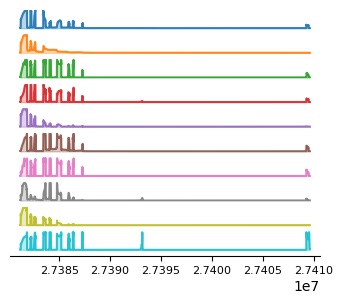

In [110]:
rds = load_ebpmf_gene('ENSG00000115241')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000115241', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

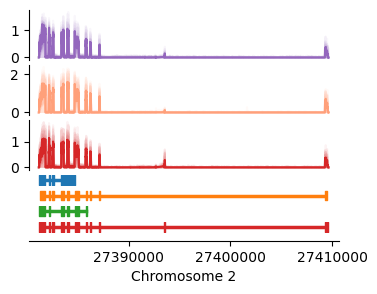

In [128]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000115241.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 8, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*4 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000115241'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000115241', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([27390000, 27400000, 27410000])
ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 2', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

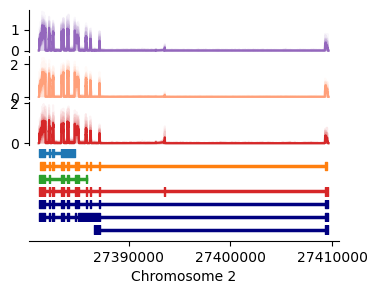

In [129]:
cols_ = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand']

gencode_srsf3 = gencode_exons.loc[gencode_exons.gene_id == 'ENSG00000115241', cols_]
gencode_srsf3['transcript_id'] = gencode_srsf3.transcript_id

srsf3_combined_annot = pd.concat([gencode_srsf3, 
           snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000115241', cols_]], axis=0)

counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000115241.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*7 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)

pkm = 'ENSG00000115241'

plot_isoform_annotations(srsf3_combined_annot, 'ENSG00000115241', colores = colores[:4] + ['navy']*3,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
ax[-1].set_xticks([27390000, 27400000, 27410000])
ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 2', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms_and_gencode.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms_and_gencode.png', bbox_inches='tight', dpi=500)

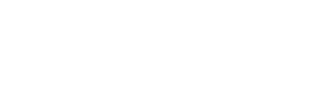

In [130]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 4, figsize=(4, 1), gridspec_kw={'height_ratios': [1.5]*4, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000115241', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

plt.savefig('../code/scratch_figures/figure2/ENSG00000115241.snmf_annot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/ENSG00000115241.snmf_annot.png', bbox_inches='tight', dpi=500)

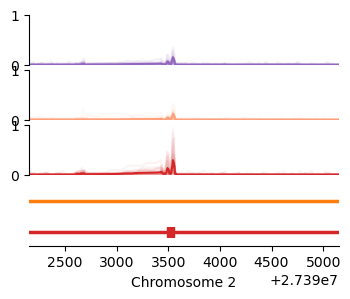

In [131]:
fig, ax = plt.subplots(nrows = 8, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*4 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])+11000
xlim2 = int(counts.columns[0].split(':')[1])+14000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# # ax[2].set_ylabel('counts')


pkm = 'ENSG00000115241'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000115241', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 2', fontsize=10)
ax[-1].set_xlim(xlim)

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
ax[2].set_ylim([0, 1])

plt.savefig('../code/scratch_figures/figure2/cassette_exon_closeup.ENSG00000115241.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon_closeup.ENSG00000115241.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

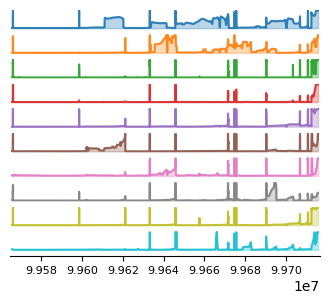

In [145]:


rds = load_ebpmf_gene('ENSG00000068305')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000068305', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

IndexError: list index out of range

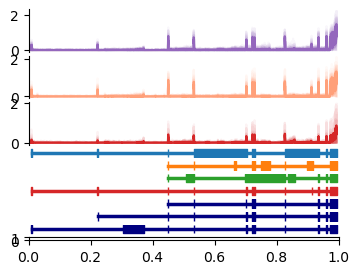

In [146]:
cols_ = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand']

gencode_srsf3 = gencode_exons.loc[gencode_exons.gene_id == 'ENSG00000068305', cols_]
gencode_srsf3['transcript_id'] = gencode_srsf3.transcript_id

srsf3_combined_annot = pd.concat([gencode_srsf3, 
           snmf_exons.loc[snmf_exons.gene_id == 'ENSG00000068305', cols_]], axis=0)

counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000068305.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*7 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)

pkm = 'ENSG00000068305'

plot_isoform_annotations(srsf3_combined_annot, 'ENSG00000068305', colores = colores[:4] + ['navy']*3,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 2', fontsize=10)
ax[-1].set_xlim(xlim)


# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000086102.counts_and_isoforms_and_gencode.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000086102.counts_and_isoforms_and_gencode.png', bbox_inches='tight', dpi=500)

In [140]:
isoform_dict

NameError: name 'isoform_dict' is not defined

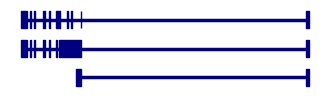

In [86]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

rds = load_ebpmf_gene('ENSG00000115241')

fig, ax = plt.subplots(nrows = 3, figsize=(4, 1), gridspec_kw={'height_ratios': [1.5]*3, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000115241', colores = ['navy']*15,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

plt.savefig('../code/scratch_figures/figure2/ENSG00000115241.gencode_annot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/ENSG00000115241.gencode_annot.png', bbox_inches='tight', dpi=500)

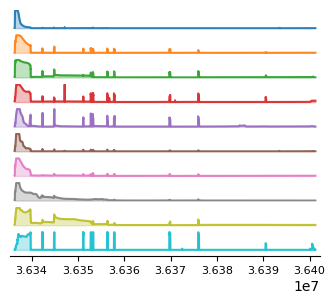

In [32]:


rds = load_ebpmf_gene('ENSG00000137075')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000137075', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

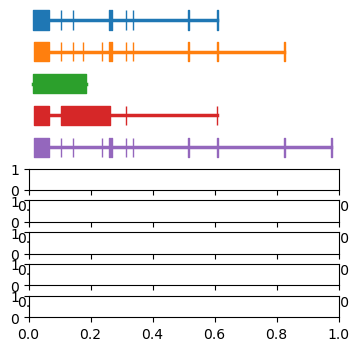

In [33]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000137075', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

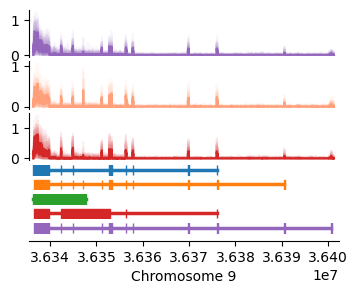

In [46]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000137075.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000137075'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000137075', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000137075.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000137075.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

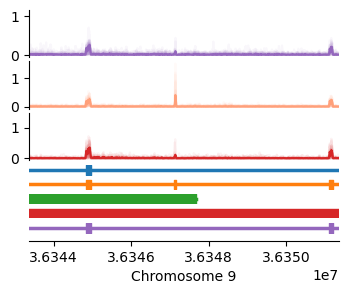

In [54]:
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])+7000
xlim2 = int(counts.columns[0].split(':')[1])+15000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000137075'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000137075', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon_closeup.ENSG00000137075.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon_closeup.ENSG00000137075.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

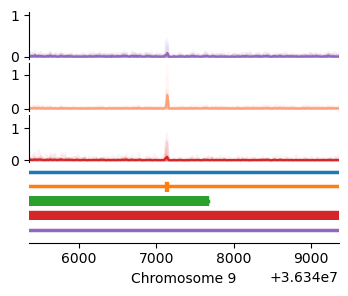

In [55]:
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])+9000
xlim2 = int(counts.columns[0].split(':')[1])+13000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000137075'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000137075', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon_closerup.ENSG00000137075.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon_closerup.ENSG00000137075.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

In [77]:
gencode_exons['chrom'] = gencode_exons['#chrom']

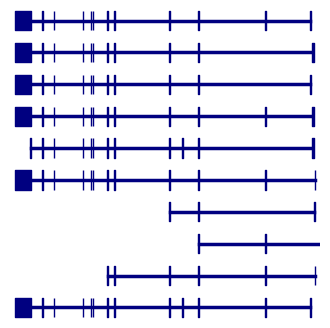

In [83]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

rds = load_ebpmf_gene('ENSG00000137075')

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000137075', colores = ['navy']*15,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

plt.savefig('../code/scratch_figures/figure2/ENSG00000137075.gencode_annot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/ENSG00000137075.gencode_annot.png', bbox_inches='tight', dpi=500)

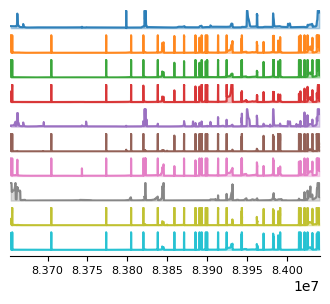

In [68]:


rds = load_ebpmf_gene('ENSG00000156218')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000156218', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

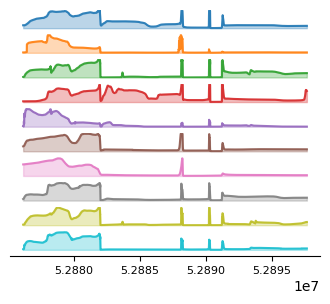

In [63]:


rds = load_ebpmf_gene('ENSG00000182986')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000182986', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

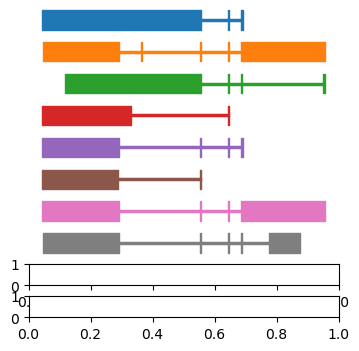

In [64]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000182986', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

IndexError: index 7 is out of bounds for axis 0 with size 7

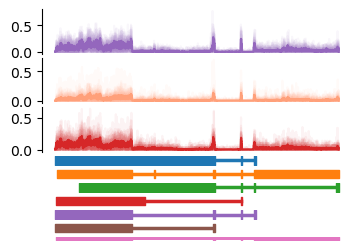

In [93]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000182986.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 10, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*6 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Brain_Cortex'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)



pkm = 'ENSG00000182986'

plot_isoform_annotations(snmf_exons, 'ENSG00000182986', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 2', fontsize=10)
ax[-1].set_xlim(xlim)


# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000115241.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

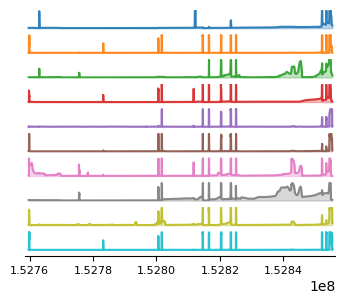

In [94]:


rds = load_ebpmf_gene('ENSG00000133627')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000133627', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

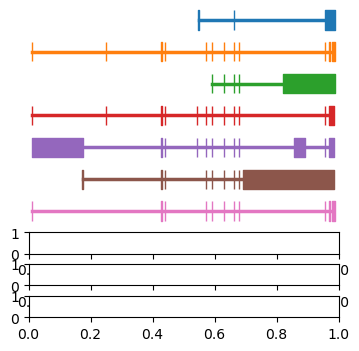

In [95]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000133627', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

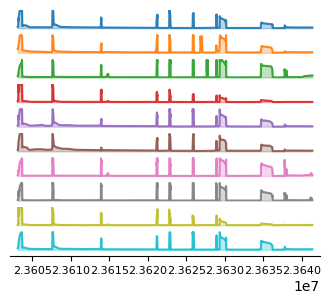

In [103]:


rds = load_ebpmf_gene('ENSG00000083093')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000083093', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

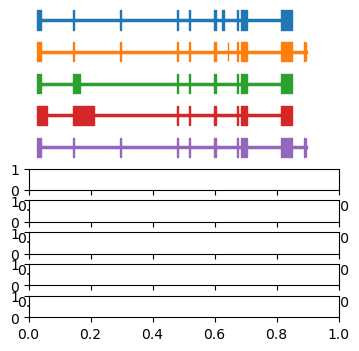

In [104]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

fig, ax = plt.subplots(nrows = 10, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*10, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000083093', colores = colores,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

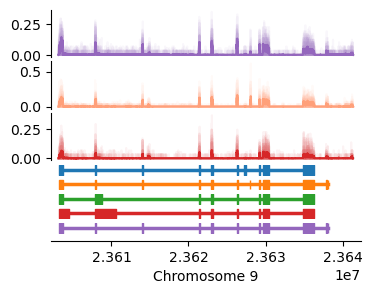

In [105]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000083093.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000083093'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000083093', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

IndexError: list index out of range

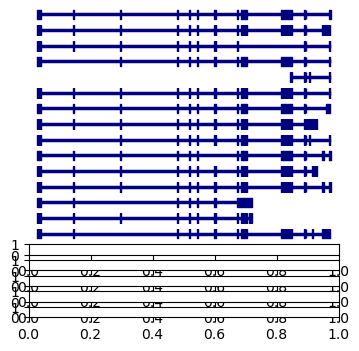

In [108]:
# snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000097007.isoform_2']

rds = load_ebpmf_gene('ENSG00000083093')

fig, ax = plt.subplots(nrows = 20, figsize=(4, 4), gridspec_kw={'height_ratios': [1.5]*20, 
                                                                               'wspace': 0.3, 'hspace': 0.5})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000083093', colores = ['navy']*15,
                         axes=ax, xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

plt.savefig('../code/scratch_figures/figure2/ENSG00000083093.gencode_annot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/ENSG00000083093.gencode_annot.png', bbox_inches='tight', dpi=500)

IndexError: index 6 is out of bounds for axis 0 with size 6

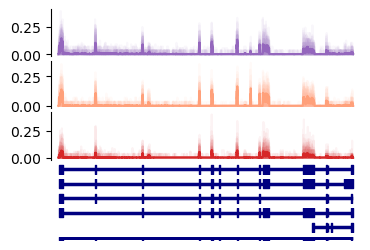

In [109]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000083093.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 9, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*5 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000083093'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000083093', colores = ['navy']*15,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms_gencode.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms_gencode.png', bbox_inches='tight', dpi=500)

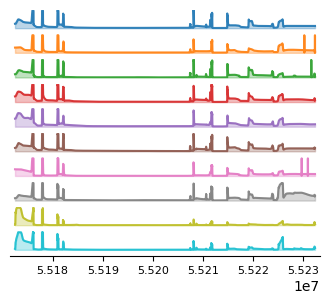

In [14]:
rds = load_ebpmf_gene('ENSG00000162994')
colores = sns.color_palette("tab10", 10)

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3.2), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})

xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

xlim = (xlim1, xlim2)


plot_factors_wrapper(rds, 'ENSG00000162994', 'ebpmf_10', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True,
                    factor_list = [f'factor{str(x+1)}' for x in range(10)])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
# ax[5].set_xticks([36595000, 36600000, 36605000])
# ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
# ax[10].set_xlabel('chromosome 6', fontsize=8)

# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.factors_5.png', bbox_inches='tight', dpi=500)

(55171497.0, 55233342.0)

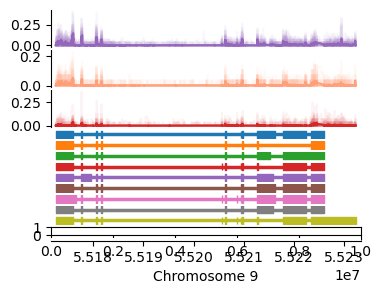

In [15]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000162994.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 24, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*20 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000162994'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(snmf_exons, 'ENSG00000162994', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.png', bbox_inches='tight', dpi=500)

In [17]:
gencode_exons['chrom'] = gencode_exons['#chrom']

IndexError: list index out of range

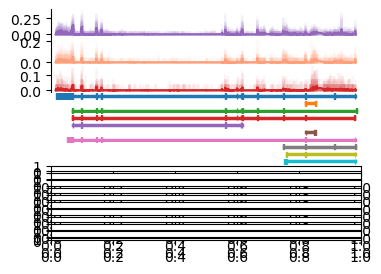

In [18]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000162994.csv.gz', index_col=0)
fig, ax = plt.subplots(nrows = 24, figsize=(4, 3), gridspec_kw={'height_ratios': [7]*3 + [1.5]*20 + [0.5], 'hspace': 0.2})

xlim1 = int(counts.columns[0].split(':')[1])-1000
xlim2 = int(counts.columns[-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

plot_counts(counts, ['Heart_Atrial_Appendage', 'Muscle_Skeletal', 'Whole_Blood'] , axes = ax[:3], 
            color_list = ['tab:purple', 'lightsalmon', 'tab:red'], xlim=xlim, k=20)


# yticks = [np.log1p(x) for x in [1, 10, 100]]
# ylabels = ['1', '10', '100']


# ax[0].set_yticks(yticks)
# ax[0].set_yticklabels(ylabels)
# ax[0].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 0.5, 1]]
# ylabels = ['0', '0.5', '1']

# ax[1].set_yticks(yticks)
# ax[1].set_yticklabels(ylabels)
# # ax[1].set_ylabel('counts')

# yticks = [np.log1p(x) for x in [0, 1, 4]]
# ylabels = ['0', '1', '4']



# ax[2].set_yticks(yticks)
# ax[2].set_yticklabels(ylabels)
# ax[2].set_ylabel('counts')


pkm = 'ENSG00000162994'
# rds = load_ebpmf_gene(pkm)

# fig, ax = plt.subplots(nrows = 7, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*6 + [0.5], 
#                                                                                'wspace': 0.3, 'hspace': 0.5})

# xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
# xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000

# xlim = (xlim1, xlim2)

# colores_order = [colores[0], colores[1], colores[4], colores[5], colores[8], colores[9]]

plot_isoform_annotations(gencode_exons, 'ENSG00000162994', colores = colores,
                         axes=ax[3:], xlim=xlim, lwidth=2.5, )#iso_order=['isoform_1', 'isoform_3', 'isoform_2', 'isoform_4'])

# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure1/SRSF3.isoforms_5.png', bbox_inches='tight', dpi=500)

ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].set_yticks([])
# ax[-1].set_xticks([27390000, 27400000, 27410000])
# ax[-1].set_xticklabels(['27390000', '27400000', '27410000'])
ax[-1].tick_params(labelsize=10)
ax[-1].set_xlabel('Chromosome 9', fontsize=10)
ax[-1].set_xlim(xlim)


# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/cassette_exon.ENSG00000083093.counts_and_isoforms.png', bbox_inches='tight', dpi=500)